# Machine Learning with the [KMNIST](https://github.com/rois-codh/kmnist) data set

### **Abstract**
This is a project which explores the [KMNIST](https://github.com/rois-codh/kmnist) data set. Each sample in this dataset is a 28x28 gray-scale image about ancient calligraphy Japanese characters (flattened as one row in the csv file) in [Kuzushiji](http://naruhodo.weebly.com/blog/introduction-to-kuzushiji (Links to an external site.)). The training dataset contains 60,000 images and the test dataset contains 10,000 images. This document was written and executed via [Google Colab](https://colab.research.google.com/?utm_source=scs-index).

The goal of the project is to see if we can train machine learning models to be able to differentiate between the 10 different characters in the dataset. The strongest results were found with the KNN method, Random forest method, and with a convolutional neural network. Clustering methods such as PCA, tSNE and K means performed poorly on the dataset. Though interstingly, PCA transformation of the data improved performance of KNN and Decision Tree methods.

### **Loading the data**

To follow along with this notebook, after running the first cell, you will need to choose the option to download the Kuzushiji-MNIST data in Numpy format. After this you will be able to run all of the remaining cells without any input needed from you.

In [ ]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:09<00:00, 1968.81KB/s]


100%|██████████| 30/30 [00:00<00:00, 450.13KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 1876.29KB/s]


100%|██████████| 6/6 [00:00<00:00, 16049.63KB/s]

All dataset files downloaded!


In [ ]:
import numpy as np

X_train = np.load('kmnist-train-imgs.npz')['arr_0']
y_train = np.int64(np.load('kmnist-train-labels.npz')['arr_0'])

X_test = np.load('kmnist-test-imgs.npz')['arr_0']
y_test = np.int64(np.load('kmnist-test-labels.npz')['arr_0'])

X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

print('Shape of X_test: '+str(X_test.shape))
print('Shape of y_test: '+str(y_test.shape))
print('Shape of X_train: '+str(X_train.shape))
print('Shape of y_train: '+str(y_train.shape))

Shape of X_test: (10000, 784)
Shape of y_test: (10000,)
Shape of X_train: (60000, 784)
Shape of y_train: (60000,)


### **Analyzing the data using a logistic regression model**



In [ ]:
import numpy as np

class myLogisticRegression():
    """ Logistic Regression classifier -- this also works for the multiclass case.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    """
    def __init__(self, learning_rate=.001, opt_method = 'SGD', num_epochs = 50, size_batch = 20):
        
        # learning rate can also be in the fit method
        self.learning_rate = learning_rate
        self.opt_method = opt_method
        self.num_epochs = num_epochs
        self.size_batch = size_batch
        
    #Fit method that has the option to use SGD 
    def fit(self, data, y, n_iterations = 1000):
        """ 
        don't forget the document string in methods
        """
        self.K = max(y)+1 # specify number of classes in y
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        eta = self.learning_rate
        
        W  = np.zeros((np.shape(X)[1],max(y)+1)) # initialize beta, can be other choices

        if self.opt_method == 'GD':
            for k in range(n_iterations):
              dW = self.loss_gradient(W,X,y) # write another function to compute gradient
              W = W - eta * dW # the formula of GD
              # this step is optional -- just for inspection purposes
              #if k % 500 == 0: # print loss every 500 steps
              #  print("loss after", k+1, "iterations is: ", self.loss(W,X,y))
        
        if self.opt_method == 'SGD':
            N = X.shape[0]
            num_epochs = self.num_epochs
            size_batch = self.size_batch
            num_iter = 0
            for e in range(num_epochs):
                shuffle_index = np.random.permutation(N) # in each epoch, we first reshuffle the data to create "randomness"
                for m in range(0,N,size_batch):   # m is the starting index of mini-batch
                    i = shuffle_index[m:m+size_batch] # index of samples in the mini-batch
                    dW = self.loss_gradient(W,X[i,:],y[i]) # only use the data in mini-batch to compute gradient. Note the average is taken in the loss_gradient function
                    W = W - eta * dW # the formula of GD, but this time dbeta is different
                
                    #if e % 1 == 0 and num_iter % 50 ==0: # print loss during the training process
                    #    print("loss after", e+1, "epochs and ", num_iter+1, "iterations is: ", self.loss(W,X,y))
        
                    num_iter = num_iter +1  # number of total iterations
            
        self.coeff = W
        
    def predict(self, data):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        W = self.coeff # the estimated W
        y_pred = np.argmax(self.sigma(X,W), axis =1) # the category with largest probability
        return y_pred
    
    def score(self, data, y_true):
        ones = np.ones((data.shape[0],1)) # column of ones 
        X = np.concatenate((ones, data), axis = 1) # the augmented matrix, \tilde{X} in our lecture
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true) # number of correct predictions/N
        return acc
    
    def sigma(self,X,W): #return the softmax probability
        s = np.exp(np.matmul(X,W))
        total = np.sum(s, axis=1).reshape(-1,1)
        return s/total
    
    def loss(self,W,X,y):
        f_value = self.sigma(X,W)
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) # avoid nan issues
        return -np.mean(loss_vector)
                          
    def loss_gradient(self,W,X,y):
        f_value = self.sigma(X,W)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X # Numpy broadcasting
            dLdW[:,k] = np.mean(dLdWk, axis=0)   # RHS is 1D Numpy array -- so you can safely put it in the k-th column of 2D array dLdW
        return dLdW

In [ ]:
#fit and score the model 
lg = myLogisticRegression(learning_rate=1e-5,opt_method = 'SGD', num_epochs = 3)
lg.fit(X_train,y_train)
lg_score=lg.score(X_test,y_test)
print('Logistic Regression Performance: '+"{:.4f}".format(lg_score))

Logistic Regression Performance: 0.6506


The performance of the logistic regression model (0.6565) is not great. We want a score as close to 1 as possible. Below we will explore more models to see if we can find a model that will be able to better classify the images.

### **Principle Component Analysis**



In [ ]:
import numpy as np

class PCA():
    '"write your document strings here"'
    
    def __init__(self, n_components = 2):
        '"write your document strings here"'
        self.n_c = n_components
        
    def fit(self,X):
        '"write your document strings here"'
        cov_mat = np.cov(X.T) # covariance matrix, the input matrix to this function does not need to be centered
        eig_val, eig_vec = np.linalg.eigh(cov_mat) #eigen-values and orthogonal eigen-vectors --ascending order
        eig_val = np.flip(eig_val) # reverse the order --descending
        eig_vec = np.flip(eig_vec,axis=1) # reverse the order
        self.eig_values = eig_val[:self.n_c] # select the top eigen-vals
        self.principal_components = eig_vec[:,:self.n_c] # select the top eigen-vecs
        self.variance_ratio = self.eig_values/eig_val.sum() # variance explained by each PC
    
    def transform(self,X):
        '"write your document strings here"'
        return np.matmul(X-X.mean(axis = 0),self.principal_components) #project the data (centered) on PCs

In [ ]:
pca = PCA(n_components = 60)
pca.fit(X_test)
X_pca = pca.transform(X_test)

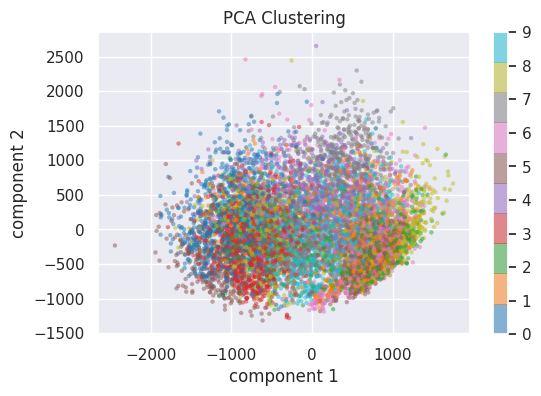

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
figure = plt.figure(dpi=100)
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=y_test, s=10, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
plt.title("PCA Clustering")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**Figure 1:** The first two components from PCA analysis are plotted against each other with the coloring represented by the true labels to visualize the clustering with this algorithm. Since there is relatively little clustering shown in the figure we can conclude that PCA alone is a poor model for classification of the characters in the data set. 










### **Exploring Methods from [Scikit-Learn](https://scikit-learn.org/stable/)**

### 1. KNN Classification - Supervised Learning

In KNN Classification, the object is classified by the "vote" of its k nearest neighbors. For example if the majority of the nearest neighbors belong to class "orange" then the value of the object will be assigned orange. In mathematical terms, given a test sample $\mathbf{x}$ from the test dataset, the kNN classifier first identifies the neighboring $k$ points in the training data that are closest to $\mathbf{x}$, whose indices are represented by $\mathcal{N}_{x}$. It then estimates the probability that $\mathbf{x}$ belongs to class $j$ by $P\big(y= j| \mathbf{x} \big)$ computing the fraction of points in $\mathcal{N}$ whose label(s) actually equal $j$:

$$
P\big(y= j| \mathbf{x} \big)\approx  \frac{1}{k} \sum_{i\in \mathcal{N}_{x}} \mathbb{1}\{ y^{(i)} = j\} =\frac{\# \textrm{points in class } j}{\# \textrm{points in neighborhood}}.
$$


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

#KNN on the original data

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
#print(knn_clf.score(X_test,y_test))
print('KNN accuracy: '+"{:.2f}".format(knn_clf.score(X_test,y_test)))

#Now perform KNN on the pca data

x_train_pca = X_train.reshape(-1, 784)
x_test_pca = X_test.reshape(-1, 784)

pca = PCA(n_components= 60 )
x_train_pca = pca.fit_transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_pca, y_train)
#print(knn_clf.score(x_test_pca,y_test)) 
print('KNN accuracy with PCA: '+"{:.4f}".format(knn_clf.score(x_test_pca,y_test)))

KNN accuracy: 0.91
KNN accuracy with PCA: 0.9341


###2. t-distributed stochastic neighbor embedding (tSNE) - Unsupervised Learning

tSNE is the most popular dimension reduction method in data science. It is great for visualization of high-dimensional data, because it alleviates the "crowding" problem in the low-dimensional embedding, by introducing the t-distribution kernel. tSNE works by constructing the transition probability matrices of random walk in high-dimensional (denoted by $P$, which is $n\times n$ matrix) and low-dimensional space (denoted by $Q$), with Gaussian and t-distribution kernels respectively. $Q$ contains the variable $y_{1},...,y_{n}\in \mathbb{R}^{k}$, i.e. reduced coordinates. tSNE tries to find the best $y_{1},...,y_{n}\in\mathbb{R}^{k}$ that minimizes the "distance" (KL divergence) between $P$ and $Q$ using gradient descent.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


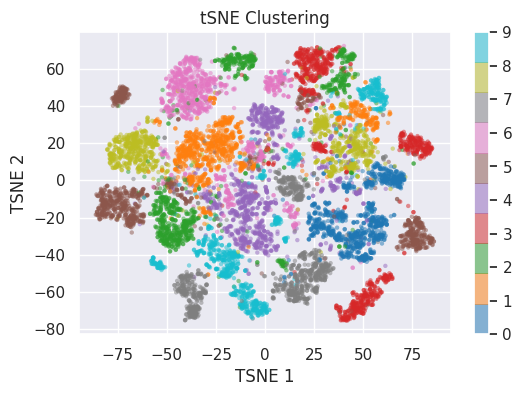

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_jobs = -1)
X_tsne = tsne.fit_transform(x_test_pca)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
figure = plt.figure(dpi=100)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y_test, s=10, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
plt.title("tSNE Clustering")
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar();

**Figure 2:** The first two components from tSNE analysis are plotted against each other with the coloring represented by the true labels to visualize the clustering with this algorithm. tSNE seems to do a better job than pca since there are more defined clusters but everything is still random - for example there are red clusters that are well grouped but there are several groups of red clusters in different locations and this is the case for the other colors as well. Therefore we can conclude that tSNE does a poor job of classifying the characters.

From these methods it is clear that KNN performs much better than logistic regression and tSNE seems to do a better job of clustering the data than PCA yet tSNE still does a poor job of classifying the data just as PCA does. Furthermore, KNN performs even better when PCA is first applied to the data, so we can conclude that even in cases when clustering methods such as PCA do a poor job of classifying the data, they can still have usefulness when used in combination with other methods such as KNN.

### **Convolutional Neural Network using [Tensorflow](https://www.tensorflow.org/)**

In this task I create a Convolutional Neural Network to classify the images. CNNs are popular for image classification tasks. They are comprised of models that condense and transform the data leaving behind its most prominent features.

In [ ]:
from numpy import asarray
from numpy import unique
from numpy import argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

Xtest1 =X_test #generate new x test and x train solely for use with this data set so we can reshape the data
Xtrain1 = X_train
Xtest1=Xtest1.reshape((Xtest1.shape[0],28,28)) #Reshape the image to 28x28 image for use with the tensor flow code below
Xtrain1=Xtrain1.reshape((Xtrain1.shape[0],28,28)) #Reshape the image to 28x28 image for use with the tensor flow code below
x_train = Xtrain1
x_test = Xtest1

# reshape data to have a single channel
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# determine the shape of the input images
in_shape = x_train.shape[1:]

# determine the number of classes
n_classes = len(unique(y_train))
print(in_shape, n_classes)

# normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# define the model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=0)

# evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy of the model: %.4f' % acc)

(28, 28, 1) 10
Accuracy of the model: 0.9368


### **Additional Methods from [Scikit-Learn](https://scikit-learn.org/stable/): K-Means Clustering, Decision Tree and Random Forest**

In [ ]:
#K means classification
from sklearn.cluster import KMeans
from sklearn import metrics
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_train)
y_km = kmeans.predict(X_test)
#metrics.adjusted_rand_score(y_test, y_km)

print('K means performance: '+"{:.2f}".format(metrics.adjusted_rand_score(y_test, y_km)))

#Decision Tree Model 
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)
dt_score=dt_clf.score(X_test,y_test)
print('decision tree performance: '+"{:.2f}".format(dt_score))

#Random Forest Method
#I didn't include the max_features=500 because if I do that the code takes forever to run
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, max_samples = 0.5, max_depth=50, n_jobs = -1) 
rf_clf.fit(X_train, y_train)
rf_score=rf_clf.score(X_test, y_test)
print('random forest performance: '+"{:.2f}".format(rf_score))


K means performance: 0.16
decision tree performance: 0.63
random forest performance: 0.85


### K-Means Clustering, Decision Tree and Random Forest on data with PCA applied

In [ ]:
#K means classification
from sklearn.cluster import KMeans
from sklearn import metrics
kmeans = KMeans(n_clusters=10)
kmeans.fit(x_train_pca)
y_km = kmeans.predict(x_test_pca)
#metrics.adjusted_rand_score(y_test, y_km)

print('K means performance on PCA data: '+"{:.2f}".format(metrics.adjusted_rand_score(y_test, y_km)))

#Decision Tree Model 
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(x_train_pca,y_train)
dt_score=dt_clf.score(x_test_pca,y_test)
print('decision tree performance on PCA data: '+"{:.2f}".format(dt_score))

#Random Forest Method
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, max_samples = 0.5, max_depth=50, n_jobs = -1) 
rf_clf.fit(x_train_pca, y_train)
rf_score=rf_clf.score(x_test_pca, y_test)
print('random forest performance on PCA data: '+"{:.2f}".format(rf_score))

K means performance on PCA data: 0.16
decision tree performance on PCA data: 0.67
random forest performance on PCA data: 0.84


From the above code it is clear that random forest does a good job of classifying the data with an accuracy of 85% while K-means and decision tree have little usefulness in classifying this data set with low accuracy scores. Though it is important to note that decision tree performed much better than K-means clustering, yet another case in which a clustering method performs poorly on the KMNIST dataset. Another thing to note is that applying PCA to the data increased decision tree performance by about 4%.

### **Discussion and Conclusions**

After testing many different models on the KMNIST data, the strongest results were found with the KNN method, Random forest method, and with a convolutional neural network. Clustering methods such as PCA, tSNE and K means performed poorly on the dataset. The top performing methods were KNN on the PCA transformed data (Accuracy of 0.9341), the CNN (Accuracy of 0.9368) and random forest (Accuracy of 0.85). It's not surprising that the CNN performed well on this dataset since CNNs are well-suited for image classification problems. While it makes sense that the random forest method would perform well since this method is well suited to large datasets.  

While the clustering algorithms performed poorly on this dataset when used alone, it is interesting to note that PCA increased performance of KNN and Decision Tree methods. This could be because PCA strips the data down to its principal components which could help KNN increase recognition of which nearest neighbors belong to which class thus resulting in higher accuracy of the method. Furthermore, PCA may have helped improve Decision Tree performance since the Decision Tree method classifies the data based on important features of a sample and PCA strips the data down to its most important features. In conclusion, for image classification tasks, transforming the data with PCA may help increase performance of KNN and Decision tree methods.